<a href="https://colab.research.google.com/github/wingated/cs474_labs_f2019/blob/master/DL_Lab5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Style Transfer Project

## Objectives
- To explore an alternative use of DNNs by implementing the style transfer algorithm ([Gatys et. al. 2016](https://arxiv.org/pdf/1508.06576.pdf)).
- To understand the importance of a complex loss function.
- To see how we can optimize not only over network parameters, but over other objects (such as images) as well.

An example image is shown below

![](https://github.com/wingated/cs474_labs/blob/master/images/style1.png?raw=true)



In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms
from tqdm import tqdm
from torch.nn.parameter import Parameter
from PIL import Image
import io
import copy
from IPython.core.ultratb import AutoFormattedTB
__ITB__ = AutoFormattedTB(mode = 'Verbose', color_scheme='LightBg', tb_offset = 1)

from google.colab import files

In [ ]:


load_and_normalize = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224,224)),
    transforms.ToTensor(),
])

def upload():
  print('Upload Content Image')
  file_dict = files.upload()
  content_path = io.BytesIO(file_dict[next(iter(file_dict))])

  print('\nUpload Style Image')
  file_dict = files.upload()
  style_path = io.BytesIO(file_dict[next(iter(file_dict))])
  return content_path, style_path

content_path, style_path = upload()

print("Content Path: {}".format(content_path))
print("Style Path: {}".format(style_path))


Upload Content Image


Saving swiss_town.png to swiss_town (3).png

Upload Style Image


Saving splatter.png to splatter.png
Content Path: <_io.BytesIO object at 0x7dd1483c3740>
Style Path: <_io.BytesIO object at 0x7dd1452d6f20>


In [ ]:
# After the images are uploaded on to the local filesystem, use:
content_image_orig = Image.open(content_path)
content_image = load_and_normalize(np.array(content_image_orig)).unsqueeze(0).cuda()
style_image_orig = Image.open(style_path)
style_image = load_and_normalize(np.array(style_image_orig)).unsqueeze(0).cuda()


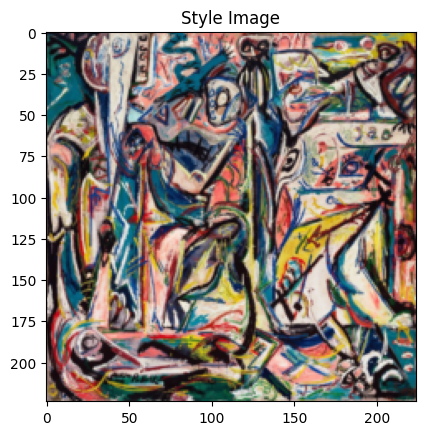

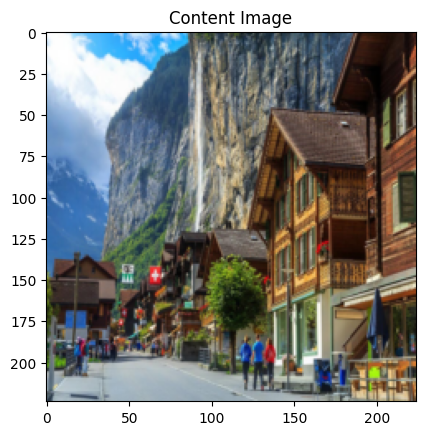

In [ ]:
# Display the images
toPIL = transforms.ToPILImage()

def display(tensor, title=None):
    image = tensor.cpu().clone()
    image = image.squeeze(0)
    image = toPIL(image)
    plt.imshow(image)
    if title is not None:
        plt.title(title)

plt.figure()
display(style_image, title='Style Image')

plt.figure()
display(content_image, title='Content Image')


___

### Part 1
Create a network instance to extract the layers needed for statistics

**TODO:**

* Correctly initialize a VGGIntermediate object to extract style and content
* Gather content statistics from the outputs of intermediate layers for the content image
* Gather style statistics for the style image

**DONE:**



In [ ]:
import torchvision.models as models

class Normalization(nn.Module):
  def __init__(self, mean=torch.tensor([0.485, 0.456, 0.406]).cuda(), std=torch.tensor([0.229, 0.224, 0.225]).cuda()):
      super(Normalization, self).__init__()
      self.mean = torch.tensor(mean).view(-1, 1, 1)
      self.std = torch.tensor(std).view(-1, 1, 1)

  def forward(self, img):
      return (img - self.mean) / self.std

class VGGIntermediate(nn.Module):
  def __init__(self, requested=[]):
    super(VGGIntermediate, self).__init__()
    self.norm = Normalization().eval()
    self.intermediates = {}
    self.vgg = models.vgg16(pretrained=True).features.eval()
    for i, m in enumerate(self.vgg.children()):
        if isinstance(m, nn.ReLU):   # we want to set the relu layers to NOT do the relu in place.
          m.inplace = False          # the model has a hard time going backwards on the in place functions.

        if i in requested:
          def curry(i):
            def hook(module, input, output):
              self.intermediates[i] = output
            return hook
          m.register_forward_hook(curry(i))

  def forward(self, x):
    self.vgg(self.norm(x))
    return self.intermediates

In [ ]:
vgg_names = ["conv1_1", "relu1_1", "conv1_2", "relu1_2", "maxpool1", "conv2_1", "relu2_1", "conv2_2", "relu2_2", "maxpool2", "conv3_1", "relu3_1", "conv3_2", "relu3_2", "conv3_3", "relu3_3","maxpool3", "conv4_1", "relu4_1", "conv4_2", "relu4_2", "conv4_3", "relu4_3","maxpool4", "conv5_1", "relu5_1", "conv5_2", "relu5_2", "conv5_3", "relu5_3","maxpool5"]

# Choose the layers to use for style and content transfer

layers = [vgg_names.index("conv4_2"),vgg_names.index("conv1_1"), vgg_names.index("conv2_1"), vgg_names.index("conv3_1"), vgg_names.index("conv4_1"), vgg_names.index("conv5_1")]

# Create the vgg network in eval mode
#  with our forward method that returns the outputs of the intermediate layers we requested

model = VGGIntermediate(layers).cuda()

content_output = model(content_image)[layers[0]]
style_output = [model(style_image)[layers[layer]] for layer in range(1,len(layers))]
# Cache the outputs of the content and style layers for their respective images

<ipython-input-70-4e86d2def5ec>:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.mean = torch.tensor(mean).view(-1, 1, 1)
<ipython-input-70-4e86d2def5ec>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.std = torch.tensor(std).view(-1, 1, 1)


___

### Part 2
Create modules for the style and content loss


**TODO:**

* Create a module that calculates the content loss in the forward method, compared to some precalculated targets stored in the object
* Create a module that calculates the style loss in the forward method using a gram matrix, compared to some precalculated targets stored in the object

**DONE:**


In [ ]:
def gram_matrix(input):
   batch, channels, height, width = input.size()
   features = input.view(batch, channels, height * width)
   gram = (torch.bmm(features, features.transpose(1,2)))/(height*width*channels)
   return gram

class ContentLoss(nn.Module):
  def __init__(self,content):
    super(ContentLoss, self).__init__()
    self.content = content.detach()

  def forward(self, combination):
    loss = F.mse_loss(combination, self.content)
    return loss

#weighting factors are implemented below
class StyleLoss(nn.Module):
  def __init__(self,style):
    super(StyleLoss, self).__init__()
    self.style = style.detach()

  def forward(self, combination):
    gram_style = gram_matrix(self.style)
    gram_comb = gram_matrix(combination)

    loss = F.mse_loss(gram_comb, gram_style)
    return loss



# Instantiate a content loss module for each content layer
#  with the content reference image outputs for that layer for comparison
content_loss_module = ContentLoss(content_output)

# Instantiate a style loss module for each style layer
#  with the style reference image outputs for that layer for comparison
style_loss_modules = [StyleLoss(i) for i in style_output]

___

### Part 3
Create and run a method that minimizes the content and style loss for a copy of the content image


**TODO:**

* Use an Adam optimizer (try learning rate of .1, but feel free to experiment)
* Show both the content and the style loss every 50 steps
* Ensure that the outputs don't go out of range (clamp them)
* Display the tensor as an image!
* Experiment with different hyperparameters or network layers until you're satisfied with your final image

**DONE:**



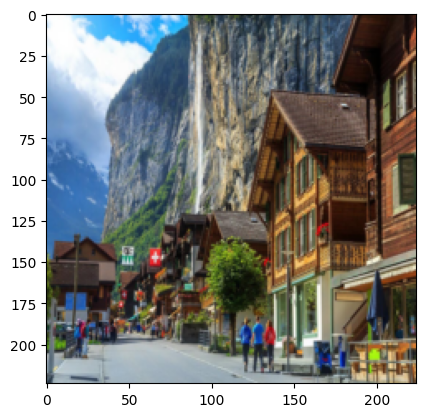

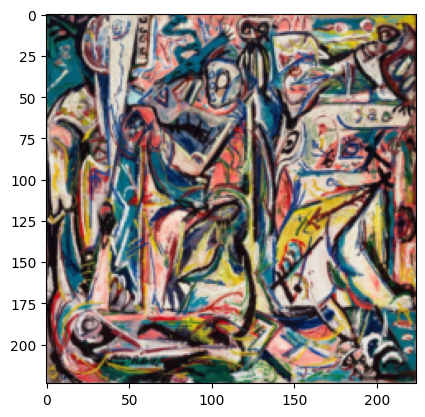

1e-06


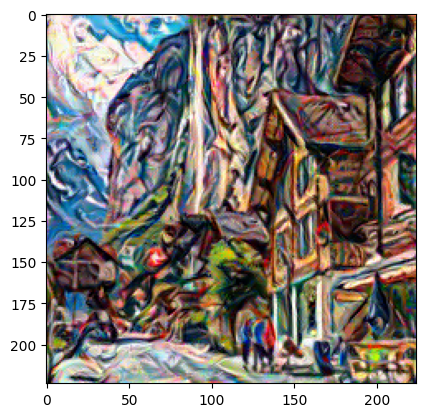

In [ ]:
# Start with a copy of the content image
combined = content_image.clone().detach()
plt.figure()
display(combined)
plt.show()

plt.figure()
display(style_image)
plt.show()
# Set the optimizer to update the image
combined = nn.Parameter(combined)
optimizer = optim.Adam([combined], lr=.01)

# (Set requires_grad to True on the image to allow it to accumulate a gradient)
combined.requires_grad_(True)

# Run the optimizer on the images to change the image
#  using the loss of the style and content layers
#  to backpropagate errors



epochs = 3000
alpha = 1
beta = 1000000
weight = 1/5
print(alpha/beta)
for epoch in range(epochs):

  optimizer.zero_grad()

  comb_content_out = model(combined)[layers[0]]
  comb_style_outputs = [model(combined)[layers[i]] for i in range(1,len(layers))]

  content_loss = content_loss_module(comb_content_out)

  sum_of_losses = 0
  for i in range(0,len(style_loss_modules)):

    curr_module = style_loss_modules[i]
    curr_output = comb_style_outputs[i]

    curr_loss = curr_module(curr_output)
    sum_of_losses += curr_loss


  style_loss = weight*sum_of_losses

  total_loss = (alpha*content_loss) + (beta*style_loss)
  total_loss.backward()

  optimizer.step()
  combined.data.clamp_(0,1)


plt.figure()
display(combined)
plt.show()
# Show the image